In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt
from glob import glob
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import random
from tqdm.notebook import tqdm






In [2]:
path = 'data/train_val/'
image_size = 572
batch_size = 8
random.seed(7)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
epochs = 50


In [14]:
class SUIM(torch.utils.data.Dataset):
    def __init__(self, datapath, transform, image_size):
        super().__init__()

        self.datapath = datapath
        self.img_paths = glob(self.datapath + "/images/*.jpg")
        self.transform = transform
        self.size = image_size

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = self.datapath + "/masks/" + img_path.split('/')[-1][:-3] + 'bmp'
        image = cv2.imread(img_path)
        dataset_mask = cv2.imread(mask_path)
        transformed = self.transform(image=image,mask=dataset_mask)
        mask = self.gen_mask(transformed['mask'])
        return transformed['image'] * 1.0, mask
    
    def gen_mask(self,dataset_mask):
        dataset_mask = T.functional.center_crop(dataset_mask.permute(2,1,0),
                                            (388,388))  
                 
        mod_mask = (dataset_mask > 100)  
        mask = np.dot(mod_mask.permute(1,2,0).numpy(), [4,2,1]).astype(np.uint8)
    
        return torch.Tensor(mask)

In [15]:
dataset = SUIM(datapath=path,
               transform= A.Compose([
                   A.PadIfNeeded(min_height=image_size, min_width=image_size,p=1),
                   A.CenterCrop(height=image_size,width=image_size,p=1),
                   ToTensorV2()]),
               image_size=image_size)
print(type(dataset))

train_data, test_data = torch.utils.data.random_split(
    dataset,
    [1220, 305],
    generator=torch.Generator().manual_seed(42)
    )
train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, num_workers=0,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size,
                          shuffle=False, num_workers=0,
                          drop_last=False)

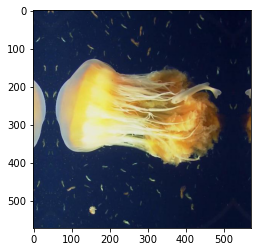

torch.Size([388, 388])


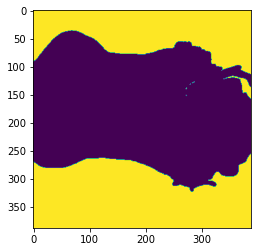

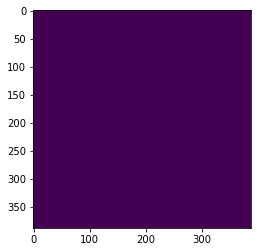

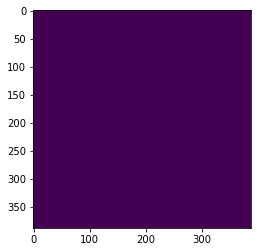

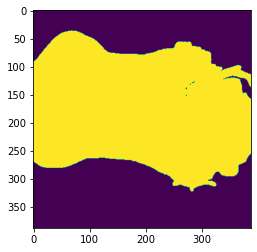

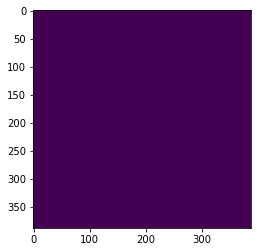

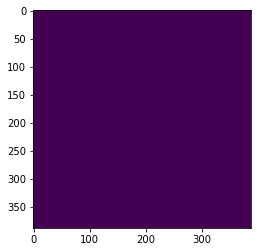

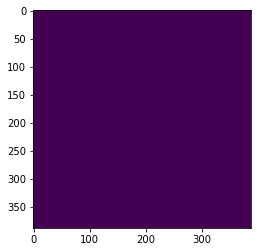

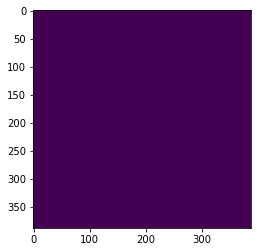

In [16]:
for data, mask in train_loader:
    data1 = data[0].permute(2,1,0).long().numpy()
    plt.imshow(data1[:,:,[2,1,0]])
    plt.show()
    print(mask[0].shape)
    for i in range(8):
        plt.imshow((mask == i)[0].numpy() *255)
        plt.show()
    break

In [17]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.conv11 = nn.Conv2d(3,64,3)
        self.conv12 = nn.Conv2d(64,64,3)
        self.max_pool2x2 = nn.MaxPool2d(2)
        self.conv21 = nn.Conv2d(64,128,3)
        self.conv22 = nn.Conv2d(128,128,3)
        self.conv31 = nn.Conv2d(128,256,3)
        self.conv32 = nn.Conv2d(256,256,3)
        self.conv41 = nn.Conv2d(256,512,3)
        self.conv42 = nn.Conv2d(512,512,3)
        self.conv51 = nn.Conv2d(512,1024,3)
        self.conv52 = nn.Conv2d(1024, 1024,3)
        self.up6 = nn.ConvTranspose2d(1024,512,2,2)
        self.conv61 = nn.Conv2d(1024,512,3)
        self.conv62 = nn.Conv2d(512,512,3)
        self.up7 = nn.ConvTranspose2d(512,256,2,2)
        self.conv71 = nn.Conv2d(512,256,3)
        self.conv72 = nn.Conv2d(256,256,3)
        self.up8 = nn.ConvTranspose2d(256,128,2,2)
        self.conv81 = nn.Conv2d(256,128,3)
        self.conv82 = nn.Conv2d(128,128,3)
        self.up9 = nn.ConvTranspose2d(128,64,2,2)
        self.conv91 = nn.Conv2d(128,64,3)
        self.conv92 = nn.Conv2d(64,64,3)
        self.conv_final = nn.Conv2d(64,8,1)
    
    def forward(self, x):
        x1 = self.conv12(self.conv11(x))
        x2 = self.conv22(self.conv21(self.max_pool2x2(x1)))
        x3 = self.conv32(self.conv31(self.max_pool2x2(x2)))
        x4 = self.conv42(self.conv41(self.max_pool2x2(x3)))
        x = self.conv52(self.conv51(self.max_pool2x2(x4)))
        x = torch.cat((self.up6(x), T.functional.center_crop(x4, (56,56))), 1)
        x = self.conv62(self.conv61(x))
        x = torch.cat((self.up7(x), T.functional.center_crop(x3, (104,104))),1)
        x = self.conv72(self.conv71(x))
        x = torch.cat((self.up8(x), T.functional.center_crop(x2, (200,200))),1)
        x = self.conv82(self.conv81(x))
        x = torch.cat((self.up9(x), T.functional.center_crop(x1, (392,392))),1)
        x = self.conv92(self.conv91(x))
        x = self.conv_final(x)

        return x




In [18]:
model = UNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [19]:
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0
    train_correct, train_total = 0,0
    for idx, (data, mask) in enumerate(tqdm(train_loader)):
        data, mask = data.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(data)
        print(output.shape)
        loss = criterion(output, mask.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred_mask = output.argmax(dim=1)
        train_correct += (mask == pred_mask).sum()
        train_total += batch_size * 388 * 388

    train_loss /= len(train_loader)
    train_acc = (100.0 * train_correct / train_total).item()
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print("Training %d / 50: Loss = %.4f, Accuracy = %2.2f%%" % (epoch, train_loss, train_acc))

    model.eval()
    test_loss = 0
    test_correct, test_total = 0,0
    with torch.no_grad():
        for idx, (data, mask) in enumerate(tqdm(test_loader)):
            data, mask = data.to(device), mask.to(device)
            output = model(data)
            loss = criterion(output, mask.long())
            test_loss = loss.item()
            pred_mask = output.argmax(dim=1)
            test_correct += (mask == pred_mask).sum()
            test_total += batch_size * 388 * 388

    test_loss /= len(test_loader)
    test_acc = (100.0 * test_correct / test_total).item()
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print("Testing Epoch %d / 50: Loss = %.4f, Accuracy = %2.2f%%" % (epoch, test_loss, test_acc))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

torch.Size([8, 8, 388, 388])
